## Zimnat Insurance Product Recommendation Challenge

In [68]:
!pip install xgboost

In [1]:
# Importing all the Required Libraries

from sklearn.metrics import classification_report, accuracy_score, make_scorer, f1_score, log_loss
import warnings
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

warnings.filterwarnings('ignore')

# Setting Random State
RANDOM_STATE = 1
np.random.seed(RANDOM_STATE)


# Installing optuna - Only for Google Collab Environment
#!pip install optuna


In [70]:
# Importing the data to pandas DataFrame
df_train = pd.read_csv('Train.csv')
df_test = pd.read_csv('Test.csv')


In [71]:
print("Training Set dimesions: ", df_train.shape)
print("Test Set dimesions: ", df_test.shape)


Training Set dimesions:  (29132, 29)
Test Set dimesions:  (10000, 29)


<AxesSubplot:>

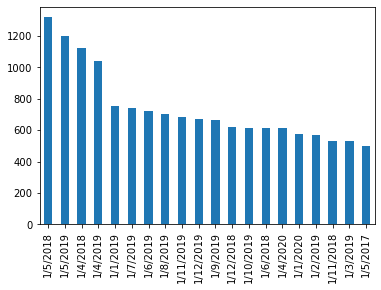

In [72]:
# Checking for Missing Values
df_train['join_date'].value_counts().sort_values(
    ascending=False).head(20).plot(kind="bar")


In [73]:
# checking for the most common date and imputing by most common
df_train['join_date'].fillna(df_train['join_date'].mode()[
                             0], inplace=True, axis=0)
df_test['join_date'].fillna(df_test['join_date'].mode()[0], inplace=True)


In [74]:
# Checking the number of Categories for Categorical Columns

for cols in df_train.columns:
    if df_train[cols].dtype == "O" and (cols not in ["ID", "join_date"]):
        print("Variable:", cols, " Number of Categories:",
              len(df_train[cols].value_counts()))


Variable: sex  Number of Categories: 2
Variable: marital_status  Number of Categories: 8
Variable: branch_code  Number of Categories: 15
Variable: occupation_code  Number of Categories: 233
Variable: occupation_category_code  Number of Categories: 6


In [75]:
# One-hot encoding for categories where we do not have many categories
cols = ['sex', 'marital_status', 'branch_code', 'occupation_category_code']
df_train = pd.get_dummies(df_train, columns=cols, prefix=cols)
df_test = pd.get_dummies(df_test, columns=cols, prefix=cols)

# Feature Engineering ------- Creating additional features

for df in [df_train, df_test]:
    df['day_joined'] = pd.DatetimeIndex(df['join_date']).day
    df['month_joined'] = pd.DatetimeIndex(df['join_date']).month
    df['year_joined'] = pd.DatetimeIndex(df['join_date']).year
    df['Age_at_join'] = df['year_joined'] - df['birth_year']
    df['time_elapsed_joined'] = (pd.to_datetime(
        '08/01/2020') - pd.DatetimeIndex(df['join_date'])).days
    df.drop(columns='join_date', inplace=True)


# We will only encode the top 95% of categories for the occupation code as there are too may categories to do one-hot
value_cum = df_train.occupation_code.value_counts().sort_values(
    ascending=False).cumsum()/df_train.shape[0]
topn_encode = value_cum[value_cum < 0.95]

topn = list(topn_encode.index)

for df in [df_train, df_test]:
    for categories in topn:
        df['occupation_code_' +
            categories] = np.where(df['occupation_code'] == categories, 1, 0)
    df.drop(columns='occupation_code', inplace=True)


In [76]:
print("Training Set dimesions: ", df_train.shape)
print("Test Set dimesions: ", df_test.shape)


Training Set dimesions:  (29132, 110)
Test Set dimesions:  (10000, 110)


In [77]:
# Setting up the dataset for use in the model
product_cols = ['P5DA', 'RIBP', '8NN1', '7POT', '66FJ', 'GYSR', 'SOP4', 'RVSZ', 'PYUQ', 'LJR9', 'N2MW',
                'AHXO', 'BSTQ', 'FM3X', 'K6QO', 'QBOL', 'JWFN', 'JZ9D', 'J9JW', 'GHYX', 'ECY3']

# Converting product to numeric label
product_ref = dict()
for i, x in enumerate(product_cols):
    product_ref[x] = i


In [78]:
# Converting the dataframe to duplicate observations across different products for the same ID
transpose_df = pd.melt(
    df_train, id_vars=['ID'], value_vars=product_cols).sort_values('ID')
transpose_df = transpose_df.loc[transpose_df.value == 1]

# Merging to main training set
merged_df = pd.merge(df_train, transpose_df, on='ID', how='left')

# Where target product in row, setting the value for product to zero


def Replace_Targets(df):
    for product in product_cols:
        if df[product] == 1 and df['variable'] == product:
            df[product] = 0

    return df


merged_df = merged_df.apply(Replace_Targets, axis=1)

# Cleaning up and remapping products to numeric values
merged_df.rename(columns={'variable': 'Target'}, inplace=True)
merged_df.drop(columns=['value'], inplace=True)
merged_df['Target'] = merged_df['Target'].map(product_ref)


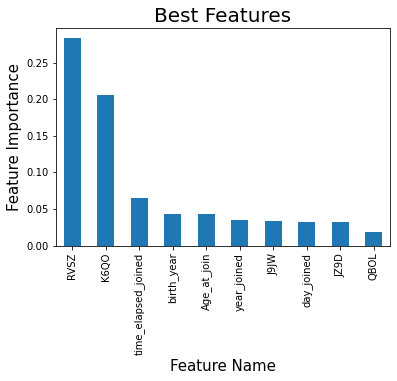

In [79]:
# Feature selection using RandomForestClassifer
Best_Features = RandomForestClassifier().fit(merged_df.drop(
    columns=["ID", "Target"]), merged_df.Target).feature_importances_

# Creating X and Y dataframes
X = merged_df.drop(columns=["ID", "Target"])
y = merged_df.Target

# Selecting the TopN Features --- Feature Selection

combined = dict(zip(X.columns, Best_Features))
FI = pd.Series(combined)


FI.sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Best Features', fontsize=20)
plt.xlabel('Feature Name', fontsize=15)
plt.ylabel('Feature Importance', fontsize=15)


BF = list(FI.sort_values(ascending=False).head(10).index)


In [80]:
# Checking the distribution of classes
merged_df['Target'].value_counts().sort_values(ascending=False)


7     25328
14    21629
15     6833
8      2173
1      1780
17     1425
18     1418
20     1102
19      902
10      838
11      539
6       431
9       354
4       339
12      324
3       316
16      311
2       157
13      110
0        40
5         4
Name: Target, dtype: int64

In [81]:
# Oversampling classes using SMOTE
from imblearn.over_sampling import SMOTE
desired_classes = {5: 50, 0: 100, 13: 200,
                   2: 300, 19: 3000, 4: 700, 6: 800, 3: 700}
sm = SMOTE(random_state=RANDOM_STATE,
           sampling_strategy=desired_classes, k_neighbors=3)
X_res, y_res = sm.fit_resample(X, y)


In [82]:
# Training the model

import xgboost as xgb
from sklearn.model_selection import train_test_split

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.3, random_state=RANDOM_STATE)

# Fitting the Model
params = {'objective': 'multi:softprob', 'num_class': 21, 'max_depth': 9,
          'eta': 0.20, 'booster': 'dart', 'reg_lambda': 30,
          'colsample_bytre': 0.35, 'subsample': 0.85, 'eval_metric': 'mlogloss', 'n_threads': 2}
num_boost_round = 999
early_stopping = 10


dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

evals = [(dtrain, 'Train'), (dtest, 'Test')]

In [83]:
# type of evals
print(type(evals))

<class 'list'>


In [84]:


model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=evals,
    early_stopping_rounds=early_stopping
)


[14:45:23] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsample_bytre", "n_threads" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	Train-mlogloss:1.75114	Test-mlogloss:1.75743
[1]	Train-mlogloss:1.46655	Test-mlogloss:1.47606
[2]	Train-mlogloss:1.26746	Test-mlogloss:1.28053
[3]	Train-mlogloss:1.11793	Test-mlogloss:1.13386
[4]	Train-mlogloss:1.00155	Test-mlogloss:1.01984
[5]	Train-mlogloss:0.90702	Test-mlogloss:0.92784
[6]	Train-mlogloss:0.83112	Test-mlogloss:0.85389
[7]	Train-mlogloss:0.76773	Test-mlogloss:0.79241
[8]	Train-mlogloss:0.71442	Test-mlogloss:0.74128
[9]	Train-mlogloss:0.66974	Test-mlogloss:0.69854
[10]	Train-mlogloss:0.63200	Test-mlogloss:0.66271
[11]	Train-mlogloss:0.5

In [85]:
# save model using booster
model.save_model('xgb.json')

In [4]:
# load model using booster
model = xgb.Booster({'nthread': 4})  # init model
model.load_model('xgb.json')  # load data

In [5]:
# convert to list
model_columns = list(model.feature_names)

In [88]:
# Making predictions of Test Set
X_test1 = df_test.drop(columns=['ID'])

# reindexing the columns, Change the order of final_test to match the order of the model
final_test = xgb.DMatrix(X_test1.reindex(columns=model_columns))

pred_prob = model.predict(final_test, ntree_limit=159)


In [89]:
# save predictions to file
pred_prob_file = pd.DataFrame(pred_prob)

In [90]:
pred_prob_file.to_csv('pred_prob_file.csv', index=False)

In [91]:
def submission(predict_prob, classes, df_test):
    ''' Creates Submission Files from 
        Probability Outputs, Product names list and 
        Test file for ID and existing product Extraction'''

    # ID Counter
    counter = 0
    # Output dictionary
    output = {'ID X PCODE': [], 'Label': []}

    # Iterating over ID values in test data
    for idd in df_test['ID'].values:
        # Iterating over all probabilities per row
        for i, prob in enumerate(predict_prob[counter]):
            # Setting product name
            product_name = classes[i]
            # Checking if current ID already has product, and set prob = 1 if so
            if df_test.loc[df_test['ID'] == idd, product_name].values[0] == 1:
                prob = 1
            output['ID X PCODE'] = output['ID X PCODE'] + \
                [str(idd) + " X " + str(product_name)]
            output['Label'] = output['Label'] + [prob]
        counter += 1
    return output


In [92]:
output = submission(pred_prob, product_cols, df_test)

In [93]:
df_submission = pd.DataFrame.from_dict(output)


In [94]:
df_submission.to_csv("data/Predictions.csv", index=False)

In [6]:
id_x_pcode = pd.read_csv("data/Predictions.csv")


In [7]:
# split ID and PCODE from ID X PCODE and make a new dataframe
id_x_pcode[['ID', 'PCODE']] = id_x_pcode['ID X PCODE'].str.split(' X ', expand=True)

In [8]:
# remove ID X PCODE column and change the order of columns as ID, PCODE, Label
id_x_pcode = id_x_pcode[['ID', 'PCODE', 'Label']]

In [9]:
# save the dataframe to csv file
id_x_pcode.to_csv("data/id_pcode_label.csv", index=False)

In [10]:
# read the csv file
id_pcode_label = pd.read_csv("data/id_pcode_label.csv")

In [11]:
id_pcode_label.head(50)

,ID,PCODE,Label
0,F86J5PC,P5DA,0.000020
1,F86J5PC,RIBP,0.000167
2,F86J5PC,8NN1,0.000014
3,F86J5PC,7POT,0.000099
4,F86J5PC,66FJ,0.000116
5,F86J5PC,GYSR,0.000021
6,F86J5PC,SOP4,0.000081
7,F86J5PC,RVSZ,1.000000
8,F86J5PC,PYUQ,0.000769
9,F86J5PC,LJR9,0.000031


In [14]:
# create a new dictionary with for unique ID as key, PCODE and Label as values
id_pcode_label_dict = {}

for i in range(len(id_pcode_label)):
    if id_pcode_label['ID'][i] not in id_pcode_label_dict:
        id_pcode_label_dict[id_pcode_label['ID'][i]] = [(id_pcode_label['PCODE'][i], id_pcode_label['Label'][i])]
    else:
        id_pcode_label_dict[id_pcode_label['ID'][i]].append((id_pcode_label['PCODE'][i], id_pcode_label['Label'][i]))

# create a new dictionary with for unique ID as key, PCODE and Label as values

In [17]:
id_pcode_label_dict['F86J5PC']

[('P5DA', 1.974434962903615e-05),
 ('RIBP', 0.0001672404323471),
 ('8NN1', 1.3940351891505998e-05),
 ('7POT', 9.93616704363376e-05),
 ('66FJ', 0.0001161444015451),
 ('GYSR', 2.1167832528590225e-05),
 ('SOP4', 8.105309825623408e-05),
 ('RVSZ', 1.0),
 ('PYUQ', 0.0007689271587878),
 ('LJR9', 3.119837128906511e-05),
 ('N2MW', 0.0001138712541433),
 ('AHXO', 4.165036443737336e-05),
 ('BSTQ', 1.3201090951042715e-05),
 ('FM3X', 2.6183717636740766e-05),
 ('K6QO', 0.9878787398338318),
 ('QBOL', 0.0069380053319036),
 ('JWFN', 4.1324503399664536e-05),
 ('JZ9D', 1.3565472727350423e-05),
 ('J9JW', 2.2813899704487994e-05),
 ('GHYX', 0.0024009251501411),
 ('ECY3', 0.0011482604313641)]

In [56]:
# convert key and values to list and sort the values by Label in descending order
id_pcode_label_dict = {k: sorted(v, key=lambda x: x[1], reverse=True) for k, v in id_pcode_label_dict.items()}
id_pcode_label_dict['F86J5PC']

[('RVSZ', 1.0),
 ('K6QO', 0.9878787398338318),
 ('QBOL', 0.0069380053319036),
 ('GHYX', 0.0024009251501411),
 ('ECY3', 0.0011482604313641),
 ('PYUQ', 0.0007689271587878),
 ('RIBP', 0.0001672404323471),
 ('66FJ', 0.0001161444015451),
 ('N2MW', 0.0001138712541433),
 ('7POT', 9.93616704363376e-05),
 ('SOP4', 8.105309825623408e-05),
 ('AHXO', 4.165036443737336e-05),
 ('JWFN', 4.1324503399664536e-05),
 ('LJR9', 3.119837128906511e-05),
 ('FM3X', 2.6183717636740766e-05),
 ('J9JW', 2.2813899704487994e-05),
 ('GYSR', 2.1167832528590225e-05),
 ('P5DA', 1.974434962903615e-05),
 ('8NN1', 1.3940351891505998e-05),
 ('JZ9D', 1.3565472727350423e-05),
 ('BSTQ', 1.3201090951042715e-05)]

In [32]:
# save id_pcode_label_dict as csv file
id_pcode_label_dict_df = pd.DataFrame.from_dict(id_pcode_label_dict, orient='index')

id_pcode_label_dict_df.to_csv("data/id_pcode_label_dict.csv")

In [60]:
# read the csv file
id_pcode_label_dict_df_read = pd.read_csv("data/id_pcode_label_dict.csv")
# convert the dataframe to dictionary
id_pcode_label_dict_df_read = id_pcode_label_dict_df_read.set_index('Unnamed: 0').T.to_dict('list')


In [62]:
# function for given a key, print top 5 values with highest probability except probablity = 1

def top_5(key):
    # sort the list of tuples by second element in descending order
    id_pcode_label_dict_df_read[key].sort(key=lambda x: x[1], reverse=True)
    # create a new list to store the top 5 values
    top_5_list = []
    # iterate over the list of tuples
    for i in range(len(id_pcode_label_dict_df_read[key])):
        # if the probability is not 1, append the tuple to the list
        if id_pcode_label_dict_df_read[key][i][1] != 1:
            top_5_list.append(id_pcode_label_dict_df_read[key][i])
        # if the length of the list is 5, break the loop
        if len(top_5_list) == 5:
            break
    return top_5_list

# def top_5_values(key):
#     return sorted(id_pcode_label_dict[key], key=lambda x: x[1], reverse=True)[:5]

top_5('F86J5PC')

["('RVSZ', 1.0)",
 "('K6QO', 0.9878787398338318)",
 "('QBOL', 0.0069380053319036)",
 "('GHYX', 0.0024009251501411)",
 "('ECY3', 0.0011482604313641)"]

In [64]:
# function for given a key, print top 5 values with highest probability except probablity = 1 in a table. And label = 1 in another table format. don't print index.

def top_5_table(key):
    # sort the list of tuples by second element in descending order
    id_pcode_label_dict[key].sort(key=lambda x: x[1], reverse=True)
    # create a new list to store the top 5 values
    top_5_list = []
    # create a new list to store the label = 1 values
    label_1_list = []
    # iterate over the list of tuples
    for i in range(len(id_pcode_label_dict[key])):
        # if the probability is not 1, append the tuple to the list
        if id_pcode_label_dict[key][i][1] != 1:
            top_5_list.append(id_pcode_label_dict[key][i])
        # if the probability is 1, append the tuple to the list
        if id_pcode_label_dict[key][i][1] == 1:
            label_1_list.append(id_pcode_label_dict[key][i])
        # if the length of the list is 5, break the loop
        if len(top_5_list) == 5:
            break
    # create a new dataframe for top 5 values
    top_5_df = pd.DataFrame(top_5_list, columns=['PCODE', 'Label'])
    # create a new dataframe for label = 1 values
    label_1_df = pd.DataFrame(label_1_list, columns=['PCODE', 'Label'])
    # create a new dataframe for top 5 values
    top_5_df = pd.DataFrame(top_5_list, columns=['PCODE', 'Label'])
    # create a new dataframe for label = 1 values
    label_1_df = pd.DataFrame(label_1_list, columns=['PCODE', 'Label'])
    # print the top 5 values in a table format
    print('Top 5 values for ID =', key)
    print(top_5_df.to_string(index=False))
    # print the label = 1 values in a table format
    print('Label = 1 values for ID =', key)
    print(label_1_df.to_string(index=False))
    

top_5_table('H6141K3')


Top 5 values for ID = H6141K3
PCODE    Label
 QBOL 0.531782
 GHYX 0.352139
 ECY3 0.067446
 JWFN 0.030746
 N2MW 0.002347
Label = 1 values for ID = H6141K3
PCODE  Label
 RVSZ    1.0
 K6QO    1.0


In [28]:
# function for each key, print top 5 values with highest probability except probablity = 1

def top_5_values():
    # create a new dictionary to store the top 5 values
    top_5_dict = {}
    # iterate over the keys in the dictionary
    for key in id_pcode_label_dict:
        # sort the list of tuples by second element in descending order
        id_pcode_label_dict[key].sort(key=lambda x: x[1], reverse=True)
        # create a new list to store the top 5 values
        top_5_list = []
        # iterate over the list of tuples
        for i in range(len(id_pcode_label_dict[key])):
            # if the probability is not 1, append the tuple to the list
            if id_pcode_label_dict[key][i][1] != 1:
                top_5_list.append(id_pcode_label_dict[key][i])
            # if the length of the list is 5, break the loop
            if len(top_5_list) == 5:
                break
        # set the key and value in the dictionary
        top_5_dict[key] = top_5_list
    return top_5_dict

top_5_dict = top_5_values()

In [30]:
# save top_5_dict as a csv file
top_5_dict_df = pd.DataFrame.from_dict(top_5_dict, orient='index')
top_5_dict_df.to_csv("data/top_5_dict.csv")

In [31]:
# read the csv file
top_5_dict_df_read = pd.read_csv("data/top_5_dict.csv")

In [12]:
# for each ID print the 5 max labels except the ones with Label = 1
for idd in id_pcode_label['ID'].unique():
    id_pcode_top5=id_pcode_label.loc[(id_pcode_label['ID'] == idd) & (id_pcode_label['Label'] != 1)].sort_values(by=['Label'], ascending=False)

# id_pcode_top5=id_pcode_label.groupby('ID').apply(lambda x: x.nlargest(5, 'Label')).reset_index(drop=True)

In [102]:
# save the dataframe to csv file
id_pcode_top5.to_csv("data/id_pcode_top5.csv", index=False)

In [3]:
# read the csv file
id_pcode_top5_read = pd.read_csv("data/id_pcode_top5.csv")

In [13]:
# print top5 labels for F86J5PC
id_pcode_top5_read.loc[id_pcode_top5_read['ID'] == 'F86J5PC']

NameError: name 'id_pcode_top5_read' is not defined

In [103]:
# for each ID print the all Labels where Label = 1
for idd in id_pcode_label['ID'].unique():
    id_pcode_exist_prod=id_pcode_label.loc[(id_pcode_label['ID'] == idd) & (id_pcode_label['Label'] == 1)].sort_values(by=['Label'], ascending=False)

In [104]:
# save the dataframe to csv file
id_pcode_exist_prod.to_csv("data/id_pcode_exist_prod.csv", index=False)

In [105]:
# read the csv file
id_pcode_exist_prod_read = pd.read_csv("data/id_pcode_exist_prod.csv")

In [106]:
# For user input ID print the top 5 products and existing products
def top5_products(id):
    print("Top 5 Products for ID: ", id)
    print(id_pcode_top5_read.loc[id_pcode_top5_read['ID'] == id])
    print("Existing Products for ID: ", id)
    print(id_pcode_exist_prod_read.loc[id_pcode_exist_prod_read['ID'] == id])

In [107]:
# input the ID and print the top 5 labels and the labels where Label = 1
input_id = input("Enter ID: ")
top5_products(input_id)